# Sub-Agent 를 활용한 컨텍스트 격리(Context Isolation) & 작업 위임(Task Delegation)

**LangChain**을 활용하여 복잡한 에이전트 시스템에서 **Context Isolation(컨텍스트 격리)** 및 **Task Delegation(작업 위임)** 을 구현하는 방법을 다룹니다.

**🏆 핵심 내용**

*   **Context Isolation**: Sub-agent를 활용한 독립적 작업 처리 및 컨텍스트 충돌 방지
*   **Sub-agent 구성**: `SubAgent` 타입 정의, 프롬프트 및 도구 할당
*   **Task Delegation**: Supervisor Agent의 작업 위임 도구(`task`) 개발
*   **실습**: Supervisor-Research Sub-agent 협업 시스템 구축
*   **LangChain 1.0**: `create_agent` 등 최신 API 적용

In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

# 환경 변수 로드
load_dotenv(override=True)
# 추적을 위한 프로젝트 이름 설정
logging.langsmith("Deep-Agent-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
Deep-Agent-Tutorial


## Context Isolation: Sub-agent 활용

![](./assets/agent_header_subagent.png)

**Context Isolation**은 복잡한 시스템에서 컨텍스트 충돌 및 오염을 방지하기 위해 각 작업을 독립된 **Sub-agent**에게 위임하는 전략입니다.

*   **필요성**: 단일 컨텍스트 윈도우 내 다목적 혼재로 인한 성능 저하 방지
*   **해결책**: 특화된 Sub-agent가 격리된 환경에서 작업 수행
*   **참고**: [LangChain Context Engineering](https://blog.langchain.com/context-engineering-for-agents/), [Anthropic Multi-agent System](https://www.anthropic.com/engineering/multi-agent-research-system)

---

### Sub-agent 위임 구조

![./assets/subagents.png](./assets/subagents.png)

*   **구조**: `subagent_type`을 Key로 하는 **Agent Registry** 활용
*   **동작**:
    1.  Main Agent가 `task(description, subagent_type)` 호출
    2.  Sub-agent가 분리된 컨텍스트에서 작업 수행
    3.  결과를 `ToolMessage`로 반환
*   **장점**: 역할 분리, 시스템 안정성 및 확장성 향상

## Sub-agent 정의

`TypedDict`를 사용하여 Sub-agent의 구성 요소(이름, 설명, 프롬프트, 도구)를 정의하고 관리합니다.

```python
class SubAgent(TypedDict):
    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]
```

*   **구성**:
    *   `name`: 에이전트 식별자(`main agent`에서 호출 시 사용)
    *   `description`: 역할 설명(`main agent`에서 호출 시 사용)
    *   `prompt`: 전용 시스템 프롬프트(`sub-agent` 작업 지시)
    *   `tools`: 사용 가능한 도구 목록(`sub-agent` 작업 도구)
*   **등록**: 리스트 형태로 관리하며 시스템에 일괄 등록

In [2]:
from typing import NotRequired
from typing_extensions import TypedDict


class SubAgent(TypedDict):
    """Configuration for a specialized sub-agent."""

    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]

하위 에이전트를 통한 컨텍스트 격리를 위한 작업 위임 도구.

이 모듈은 격리된 컨텍스트를 가진 하위 에이전트를 생성하고 관리하기 위한 핵심 인프라를 제공합니다. 

하위 에이전트는 특정 작업 설명만 포함된 깨끗한 컨텍스트 창으로 작동함으로써 **컨텍스트 충돌을 방지**합니다.

In [3]:
from typing import Annotated
from langchain_core.messages import ToolMessage
from langchain_core.tools import BaseTool, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langchain.agents import create_agent

from langgraph.types import Command

from deep_agents_from_scratch.prompts import TASK_DESCRIPTION_PREFIX
from deep_agents_from_scratch.state import DeepAgentState


def _create_task_tool(tools, subagents: list[SubAgent], model, state_schema):
    """Create a task delegation tool that enables context isolation through sub-agents.

    This function implements the core pattern for spawning specialized sub-agents with
    isolated contexts, preventing context clash and confusion in complex multi-step tasks.

    Args:
        tools: List of available tools that can be assigned to sub-agents
        subagents: List of specialized sub-agent configurations
        model: The language model to use for all agents
        state_schema: The state schema (typically DeepAgentState)

    Returns:
        A 'task' tool that can delegate work to specialized sub-agents
    """
    # Sub-agent 레지스트리 딕셔너리 생성, 이름을 키로 하여 에이전트 인스턴스 저장
    agents = {}

    # 도구 이름별 매핑 딕셔너리 생성, Sub-agent별 도구 할당에 활용
    tools_by_name = {}
    for tool_ in tools:
        if not isinstance(tool_, BaseTool):
            tool_ = tool(tool_)
        tools_by_name[tool_.name] = tool_

    # Sub-agent 구성 정보 기반으로 특화 에이전트 생성 및 레지스트리에 등록
    for _agent in subagents:
        if "tools" in _agent:
            # Sub-agent에 지정된 도구만 할당
            _tools = [tools_by_name[t] for t in _agent["tools"]]
        else:
            # 도구 미지정 시 전체 도구 할당
            _tools = tools
        agents[_agent["name"]] = create_agent(
            model,
            system_prompt=_agent["prompt"],
            tools=_tools,
            state_schema=state_schema,
        )

    # 사용 가능한 Sub-agent 목록을 도구 설명에 활용하기 위한 문자열 리스트 생성
    other_agents_string = [
        f"- {_agent['name']}: {_agent['description']}" for _agent in subagents
    ]

    @tool(description=TASK_DESCRIPTION_PREFIX.format(other_agents=other_agents_string))
    def task(
        description: str,
        subagent_type: str,
        state: Annotated[DeepAgentState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Delegate a task to a specialized sub-agent with isolated context.

        This creates a fresh context for the sub-agent containing only the task description,
        preventing context pollution from the parent agent's conversation history.
        """
        # 요청된 Sub-agent 타입이 레지스트리에 존재하는지 검증, 미존재 시 에러 반환
        if subagent_type not in agents:
            return f"Error: invoked agent of type {subagent_type}, the only allowed types are {[f'`{k}`' for k in agents]}"

        # 요청된 Sub-agent 인스턴스 가져오기
        sub_agent = agents[subagent_type]

        # 작업 설명만 포함된 격리된 컨텍스트 생성, 부모 에이전트의 히스토리 미포함
        state["messages"] = [{"role": "user", "content": description}]

        # 격리된 환경에서 Sub-agent 실행 및 결과 획득
        result = sub_agent.invoke(state)

        # 작업 결과를 Command 객체로 래핑하여 부모 에이전트에 ToolMessage 형태로 반환
        return Command(
            update={
                "files": result.get("files", {}),  # 파일 변경 사항 병합
                "messages": [
                    # Sub-agent의 마지막 메시지를 ToolMessage로 변환하여 반환
                    ToolMessage(
                        result["messages"][-1].content, tool_call_id=tool_call_id
                    )
                ],
            }
        )

    return task

## Step 2: Task Delegation 도구 개발

Sub-agent에게 작업을 위임하고 결과를 수신하는 `task` 도구를 구현합니다.

*   **기능**: 작업 설명(`description`)과 Sub-agent 타입(`subagent_type`)을 입력받아 위임
*   **Context Isolation**:
    *   부모 에이전트의 히스토리를 제외하고, 작업 설명만 포함된 **새로운 컨텍스트** 생성
    *   Sub-agent는 격리된 환경에서 실행
*   **결과 반환**:
    *   `Command` 객체를 통해 파일 변경 사항(`files`) 병합
    *   Sub-agent의 최종 응답을 `ToolMessage`로 변환하여 부모에게 전달

In [4]:
# Sub-agent 사용법 프롬프트 출력 함수 호출, Supervisor Agent 프롬프트 설계 참고 목적
from utils import show_prompt

from deep_agents_from_scratch.prompts import SUBAGENT_USAGE_INSTRUCTIONS

show_prompt(SUBAGENT_USAGE_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your role is to coordinate research by delegating specific research tasks to sub-agents.                       │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  1. **task(description, subagent_type)**: Delegate research tasks to specialized sub-agents                     │
│     - description: Clear, specific research question or task                                                    │
│     - subagent_type: Type of agent to use (e.g., "research-agent")                                              │
│  2. **think_tool(reflection)**: Reflect on the results of each delegated task and plan next steps.              │
│     - reflection: Your detailed reflection on the results of the task and next steps.                           │
│                                                                                                                 │
│  **PARALLEL RESEARCH**: When you identify multiple independent research directions, make multiple **task**      │
│  tool calls in a single response to enable parallel execution. Use at most {max_concurrent_research_units}      │
│  parallel agents per iteration.                                                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Task Delegation Budgets** (Prevent excessive delegation):                                                    │
│  - **Bias towards focused research** - Use single agent for simple questions, multiple only when clearly        │
│  beneficial or when you have multiple independent research directions based on the user's request.              │
│  - **Stop when adequate** - Don't over-research; stop when you have sufficient information                      │
│  - **Limit iterations** - Stop after {max_researcher_iterations} task delegations if you haven't found          │
│  adequate sources                                                                                               │
│  </Hard Limits>                                                                                                 │
│                                                                                                                 │
│  <Scaling Rules>                                                                                                │
│  **Simple fact-finding, lists, and rankings** can use a single sub-agent:                                       │
│  - *Example*: "List the top 10 coffee shops in San Francisco" → Use 1 sub-agent, store in                       │
│  `findings_coffee_shops.md`                                                                                     │
│                                                                                                                 │
│  **Comparisons** can use a sub-agent for each element 

In [5]:
print(SUBAGENT_USAGE_INSTRUCTIONS)

You can delegate tasks to sub-agents.

<Task>
Your role is to coordinate research by delegating specific research tasks to sub-agents.
</Task>

<Available Tools>
1. **task(description, subagent_type)**: Delegate research tasks to specialized sub-agents
   - description: Clear, specific research question or task
   - subagent_type: Type of agent to use (e.g., "research-agent")
2. **think_tool(reflection)**: Reflect on the results of each delegated task and plan next steps.
   - reflection: Your detailed reflection on the results of the task and next steps.

**PARALLEL RESEARCH**: When you identify multiple independent research directions, make multiple **task** tool calls in a single response to enable parallel execution. Use at most {max_concurrent_research_units} parallel agents per iteration.
</Available Tools>

<Hard Limits>
**Task Delegation Budgets** (Prevent excessive delegation):
- **Bias towards focused research** - Use single agent for simple questions, multiple only when clea

**필수: 모든 리서치 작업은 반드시 서브 에이전트에게 위임해야 함. 조율자 역할이며 직접 리서치 수행자가 아님.**

**<작업>**

리서치 조율 역할 수행. 특정 리서치 작업을 서브 에이전트에게 위임. 반드시 task 도구를 사용하여 작업 위임 - 직접 리서치 수행 금지.

**<필수 워크플로우>**

**1단계 - 요청 분석:**

- 필요한 리서치 내용 파악
- 단일 또는 복수 리서치 방향 필요 여부 식별
- 사용할 적절한 서브 에이전트 유형 결정

**2단계 - 즉시 위임:**

- 모든 리서치 요청에 대해 **task** 도구를 첫 번째 작업으로 **반드시** 호출
- 직접 리서치 수행 고려 금지 - 즉시 위임
- 자체 완결적이고 명확하며 구체적인 작업 설명 사용

**3단계 - 검토 및 종합:**

- 서브 에이전트 결과 수신 후 **think_tool**로 검토
- 추가 리서치 필요 여부 판단
- 추가 리서치 필요 시 **task** 도구로 재위임
- 충분한 정보 수집 시 종합하여 최종 답변 제공

**4단계 - 최종 답변 제공:**

- 모든 서브 에이전트 결과 통합
- 사용자에게 종합적인 답변 제시

**<사용 가능한 도구>**

1. **task(description, subagent_type)**: **주요 도구** - 전문 서브 에이전트에게 리서치 작업 위임
   - description: 명확하고 구체적인 리서치 질문 또는 작업 (자체 완결적이고 완전해야 함)
   - subagent_type: 사용할 에이전트 유형 (예: "research-agent")
   - **모든 리서치 작업에 이 도구 사용 - 직접 리서치 시도 금지**

2. **think_tool(reflection)**: 위임된 각 작업 결과 검토 및 다음 단계 계획
   - reflection: 작업 결과와 다음 단계에 대한 상세 검토 내용
   - 서브 에이전트 결과 수신 후 다음 작업 결정에 사용

**병렬 리서치**: 여러 독립적인 리서치 방향 식별 시, 단일 응답에서 여러 **task** 도구 호출로 병렬 실행 가능. 반복당 최대 {max_concurrent_research_units}개 병렬 에이전트 사용.

**<필수 규칙>**

**⚠️ 위임은 필수:**

- 모든 리서치 요청에 **task** 도구 **항상** 사용
- 리서치 질문에 직접 답변 시도 **금지**
- (사용 가능하더라도) 검색 도구 직접 사용 **금지** - 서브 에이전트에게 위임
- 역할은 조율이며, 직접 리서치 실행이 아님

**위임 시점:**

- 사용자가 보유하지 않은 정보 요청 시 → 즉시 위임
- 사용자가 비교 분석 요청 시 → 각 요소별 개별 작업 위임
- 사용자가 다면적 리서치 요청 시 → 각 측면별 병렬 작업 위임
- 사용자가 목록 또는 순위 요청 시 → 단일 서브 에이전트에게 위임

**<엄격한 제한>**

**작업 위임 예산** (과도한 위임 방지):

- **집중된 리서치 지향** - 단순 질문은 단일 에이전트 사용, 명확한 이점이 있거나 사용자 요청 기반 여러 독립적 리서치 방향이 있을 때만 복수 사용
- **충분할 때 중단** - 과도한 리서치 지양, 충분한 정보 확보 시 중단
- **반복 제한** - {max_researcher_iterations}회 작업 위임 후에도 적절한 소스 미확보 시 중단

**<확장 규칙>**

**단순 사실 조사, 목록, 순위** → 서브 에이전트 1개 사용:

- *예시*: "샌프란시스코 상위 10개 커피숍 목록" → 서브 에이전트 1개 사용, `findings_coffee_shops.md`에 저장

**비교 분석** → 요소당 서브 에이전트 1개 사용:

- *예시*: "OpenAI vs. Anthropic vs. DeepMind AI 안전성 접근 방식 비교" → 서브 에이전트 3개 사용
- 개별 파일에 결과 저장: `findings_openai_safety.md`, `findings_anthropic_safety.md`, `findings_deepmind_safety.md`

**다면적 리서치** → 각 측면별 병렬 에이전트 사용:

- *예시*: "재생 에너지 리서치: 비용, 환경 영향, 도입률" → 서브 에이전트 3개 사용
- 측면별로 개별 파일에 결과 정리

**<주요 참고사항>**

- 각 **task** 호출은 격리된 컨텍스트를 가진 전용 리서치 에이전트 생성
- 서브 에이전트는 상호 작업 내용 확인 불가 - 완전한 독립 지침 제공 필요
- 명확하고 구체적인 언어 사용 - 작업 설명에 약어 또는 축약어 사용 지양
- 작업 설명은 자체 완결적이어야 함 - 서브 에이전트는 전체 대화 컨텍스트 접근 불가

## Sub-agent 정의 및 설정

`_create_task_tool`을 사용하여 구체적인 Sub-agent를 정의하고 시스템에 통합합니다.

*   **Sub-agent의 이중 역할**:
    *   **도구**: Supervisor에게 호출 방법 제공
    *   **에이전트**: 독립적 프롬프트 및 도구 세트로 작업 수행
*   **예시: Research Sub-agent**:
    *   `description`: 단일 주제 연구 위임 명시
    *   `tools`: `web_search` 할당
    *   **효과**: 특정 작업에 한정된 독립 컨텍스트에서 동작하여 충돌 방지
*   **Supervisor 프롬프트**: Sub-agent 호출 방법 및 병렬 처리 지침 포함 필수

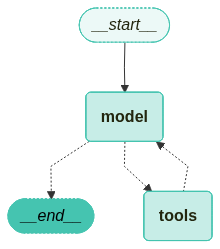

In [6]:
from datetime import datetime

from IPython.display import display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain.agents import create_agent
from langchain_teddynote.graphs import visualize_graph

# 동시 연구 작업 단위 최대 개수 제한 설정
max_concurrent_research_units = 3
# 연구자 에이전트 반복 횟수 최대값 설정
max_researcher_iterations = 3


# 웹 검색 도구 모킹 함수 정의, 실제 검색 대신 고정된 결과 반환
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from the search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    # 웹 검색 결과 모킹 데이터 정의, 실제 검색 대신 고정된 결과 반환
    search_result = """The Model Context Protocol (MCP) is an open standard protocol developed
by Anthropic to enable seamless integration between AI models and external systems like
tools, databases, and other services. It acts as a standardized communication layer,
allowing AI models to access and utilize data from various sources in a consistent and
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants
to external services by providing a unified language for data exchange. """
    return search_result


# 연구용 Sub-agent 프롬프트 문자열 정의, 단일 웹 검색만 허용
SIMPLE_RESEARCH_INSTRUCTIONS = """You are a researcher. Research the topic provided to you. IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the provided topic."""

# 연구용 Sub-agent 구성 정보 딕셔너리 생성, 이름/설명/프롬프트/도구 지정
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": SIMPLE_RESEARCH_INSTRUCTIONS,
    "tools": ["web_search"],
}

# 위에서 초기화된 기본 LLM 사용, 모델 및 온도 설정
model = init_chat_model(model="anthropic:claude-sonnet-4-5", temperature=0.0)

# Sub-agent에 할당할 도구 리스트 정의, 웹 검색 도구 포함
sub_agent_tools = [web_search]

# Sub-agent에게 작업 위임을 위한 task 도구 생성, 컨텍스트 격리 구현
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

# Supervisor Agent가 사용할 도구 리스트, task 도구 포함
delegation_tools = [task_tool]

# Supervisor Agent 생성, 시스템 프롬프트 및 상태 스키마 지정
agent = create_agent(
    model,
    delegation_tools,
    system_prompt=SUBAGENT_USAGE_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
        date=datetime.now().strftime("%a %b %-d, %Y"),
    ),
    state_schema=DeepAgentState,
)

# 에이전트의 내부 구조 시각화, Mermaid 그래프 이미지 출력
visualize_graph(agent)

In [7]:
from langchain_teddynote.messages import invoke_graph

inputs = {
    "messages": [
        {
            "role": "user",
            "content": "Give me an overview of Model Context Protocol (MCP).",
        }
    ],
}
invoke_graph(agent, inputs)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

[{'text': "I'll research the Model Context Protocol (MCP) for you.", 'type': 'text'}, {'id': 'toolu_01A9xSsbnNz6znRwcWsLPTob', 'input': {'description': 'Research and provide a comprehensive overview of Model Context Protocol (MCP). Include what it is, its purpose, key features, how it works, who developed it, main use cases, and its significance in the AI/technology landscape.', 'subagent_type': 'research-agent'}, 'name': 'task', 'type': 'tool_use'}]
Tool Calls:
  task (toolu_01A9xSsbnNz6znRwcWsLPTob)
 Call ID: toolu_01A9xSsbnNz6znRwcWsLPTob
  Args:
    description: Research and provide a comprehensive overview of Model Context Protocol (MCP). Include what it is, its purpose, key features, how it works, who developed it, main use cases, and its significance in the AI/technology landscape.
    subagent_type: research-agent

🔄 Node: model i

실행 결과 확인하기: https://smith.langchain.com/public/4dee1f7f-d8d4-4241-a053-cc7ba8678822/r